# Colab Code

from google.colab import drive
drive.mount('/content/drive')

import shutil
import os
 
FILE_NAME = "Data.zip"
 
def copy_zip_file(src_path, dest_dir):
 
    zip_filename = os.path.basename(src_path)
    dest_path = os.path.join(dest_dir, zip_filename)
 
    if not os.path.exists(src_path):
        print(f"Error: The file '{src_path}' does not exist.")
        return
 
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
 
    shutil.copy2(src_path, dest_path)
    print(f"'{zip_filename}' has been copied to '{dest_dir}'.")
 
source_path = "/content/drive/MyDrive/" + FILE_NAME
destination_directory = "/content"
 
copy_zip_file(source_path, destination_directory)

!unzip Data.zip

tf.config.list_physical_devices('GPU')

if tf.test.gpu_device_name(): 

    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:

   print("Please install GPU version of TF")

print(f"-> {tf.config.list_physical_devices('GPU')}")

import tensorflow as tf

print(tf.__version__)

In [1]:
# imports 
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import tensorflow as tf
from collections import Counter
import random
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler
import shutil

# Read data

In [ ]:
# Define Paths
dataset_dir = "Data"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

In [15]:

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Load Dataset
def load_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y))
    return dataset



In [ ]:
# Apply preprocessing so all datasets contain image tensors (not paths)
preprocessed_dataset = load_dataset(image_paths, labels)

# Split by class
class_2_dataset = preprocessed_dataset.filter(lambda img, label: tf.equal(label, 2)).shuffle(buffer_size=1000).take(15_000)
class_3_dataset = preprocessed_dataset.filter(lambda img, label: tf.equal(label, 3))
class_0_dataset = preprocessed_dataset.filter(lambda img, label: tf.equal(label, 0))
class_1_dataset = preprocessed_dataset.filter(lambda img, label: tf.equal(label, 1))

# Combine the datasets
final_dataset = (class_2_dataset
                 .concatenate(class_3_dataset)
                 .concatenate(class_0_dataset)
                 .concatenate(class_1_dataset))

In [ ]:

label_counts = Counter()

# Loop through dataset
for _, lbl in final_dataset:
    class_index = int(lbl.numpy())  # Convert one-hot to class index
    label_counts[class_index] += 1

# Print class distribution
print("Final dataset class distribution:")
for label, count in sorted(label_counts.items()):
    print(f"Class {label}: {count} images")


In [ ]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np

def save_dataset_to_folder(dataset, folder_path, class_names):
    os.makedirs(folder_path, exist_ok=True)

    for class_name in class_names:
        class_dir = os.path.join(folder_path, class_name)
        os.makedirs(class_dir, exist_ok=True)

    counter = [0] * len(class_names)  # To count how many images per class

    for image, label in dataset:
        # If label is one-hot encoded, convert to integer
        if tf.rank(label) > 0:
            label = tf.argmax(label, axis=-1)

        print(label)
        label = int(label.numpy())
        class_name = class_names[label]

        # Convert tensor to numpy and save as PNG
        image_np = image.numpy()
        if image_np.dtype != 'uint8':
            image_np = (image_np * 255).astype('uint8')  # normalize if needed

        img = Image.fromarray(image_np)
        img_path = os.path.join(folder_path, class_name, f'{counter[label]}.jpg')
        img.save(img_path)

        counter[label] += 1



In [ ]:
save_dataset_to_folder(final_dataset, "final_dataset", classes)


In [ ]:
# Define Paths
dataset_dir = "final_dataset"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

In [ ]:
# Split data into training, testing and validation
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.3, random_state=42,stratify=labels) # suffle by default and straity labels 
test_paths, val_paths, test_labels, val_labels = train_test_split(test_paths, test_labels, test_size=0.5, random_state=42,stratify=test_labels) # suffle by default and straity labels
# to keep the same class distribution

In [ ]:
train_dataset = load_dataset(train_paths, train_labels)
val_dataset = load_dataset(val_paths, val_labels)
test_dataset = load_dataset(test_paths, test_labels)

In [ ]:
save_dataset_to_folder(train_dataset, "train_dataset", classes)
save_dataset_to_folder(val_dataset, "val_dataset", classes)
save_dataset_to_folder(test_dataset, "test_dataset", classes)

# Data Agumentation

In [2]:
# Define Paths
dataset_dir = "train_dataset"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

Class: Mild Dementia, Files Found: 3501
Class: Moderate Dementia, Files Found: 342
Class: Non Demented, Files Found: 10500
Class: Very mild Dementia, Files Found: 9607


In [3]:
path_train = "train_dataset"
path_val = "val_dataset"
#Rescale data and create data generator instances
# train_datagenerator = ImageDataGenerator(rescale=1/255.)
val_datagenerator = ImageDataGenerator(rescale=1/255.)
train_datagenerator_augmentation = ImageDataGenerator(rescale = 1/255.,
                                                      rotation_range=20, #rotate the image
                                                      zoom_range = 0.2,#zoom the image
                                                      width_shift_range=0.2, #shift the image horizontally
                                                      height_shift_range=0.2, #shift the image vertically
                                                      horizontal_flip=True, #flip the image on horizontal axis
                                                      vertical_flip=True, #flip the image on vertical axis
                                                      shear_range = 0.2) #Shear the image



In [4]:
#Load data in from images and turn into batches
# train_data = train_datagenerator.flow_from_directory(path_treino,
#                                                      target_size=(128,128),
#                                                      batch_size=32,
#                                                      class_mode='categorical'
#                                                     )
val_data = val_datagenerator.flow_from_directory(path_val,
                                                     target_size=(128,128),
                                                     batch_size=32,
                                                     class_mode='categorical'
                                                    )
train_data_augmented = train_datagenerator_augmentation.flow_from_directory(path_train,
                                                                            target_size=(128,128),
                                                                            batch_size=32,
                                                                            class_mode='categorical',
                                                                            shuffle=True)

Found 5133 images belonging to 4 classes.
Found 23950 images belonging to 4 classes.


In [ ]:
# def save_dataset_to_folder_augmented(dataset, folder_path, class_names):
#     os.makedirs(folder_path, exist_ok=True)

#     for class_name in class_names:
#         class_dir = os.path.join(folder_path, class_name)
#         os.makedirs(class_dir, exist_ok=True)

#     counter = [0] * len(class_names)  # To count how many images per class

#     for image, label in dataset:
#         # If label is one-hot encoded, convert to integer
#         if tf.rank(label) > 0:
#             label = tf.argmax(label, axis=-1)  # This will give the class index

#         # Now loop over the batch of labels and process each image
#         for i in range(len(label)):
#             single_label = int(label[i].numpy())  # Convert individual label to int
#             class_name = class_names[single_label]

#             # Convert tensor to numpy and save as PNG
#             image_np = image[i]  # Access the i-th image in the batch (no need for .numpy())
#             if image_np.dtype != 'uint8':
#                 image_np = (image_np * 255).astype('uint8')  # normalize if needed

#             img = Image.fromarray(image_np)
#             img_path = os.path.join(folder_path, class_name, f'{counter[single_label]}.jpg')
#             img.save(img_path)

#             counter[single_label] += 1


In [ ]:
# save_dataset_to_folder_augmented(train_data_augmented, "train_dataset_augmentation", classes)

In [5]:
# Define the CNN model
def create_cnn(num_classes=4):
    model = keras.Sequential([
        # Convolutional Block 1
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        
        # Convolutional Block 2
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        
        # Convolutional Block 3
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.BatchNormalization(),
        
        # Flatten & Dense Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),  # Reduce overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        # loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model



In [6]:
# Create the model
cnn_model = create_cnn()

# Print model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                        

In [7]:
# Train the model

cnn_model.fit(train_data_augmented, validation_data=val_data, epochs=300)



Epoch 1/300


2025-04-10 00:56:14.424677: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


749/749 [==============================] - 113s 150ms/step - loss: 1.1849 - accuracy: 0.5148 - val_loss: 1.0982 - val_accuracy: 0.5283
Epoch 2/300
749/749 [==============================] - 120s 160ms/step - loss: 0.9173 - accuracy: 0.6068 - val_loss: 0.8904 - val_accuracy: 0.6199
Epoch 3/300
749/749 [==============================] - 124s 166ms/step - loss: 0.8789 - accuracy: 0.6216 - val_loss: 0.8825 - val_accuracy: 0.5993
Epoch 4/300
749/749 [==============================] - 139s 186ms/step - loss: 0.8509 - accuracy: 0.6385 - val_loss: 0.9642 - val_accuracy: 0.6205
Epoch 5/300
749/749 [==============================] - 136s 182ms/step - loss: 0.8319 - accuracy: 0.6419 - val_loss: 1.0854 - val_accuracy: 0.4818
Epoch 6/300
749/749 [==============================] - 145s 193ms/step - loss: 0.8198 - accuracy: 0.6481 - val_loss: 0.7710 - val_accuracy: 0.6561
Epoch 7/300
749/749 [==============================] - 148s 197ms/step - loss: 0.8021 - accuracy: 0.6555 - val_loss: 1.0358 - val_

In [8]:
# Save the Model
cnn_model.save("alzheimers_detection_model_FJSL.h5")

In [10]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

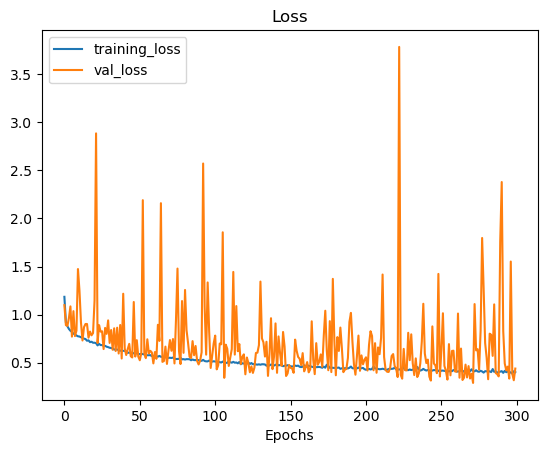

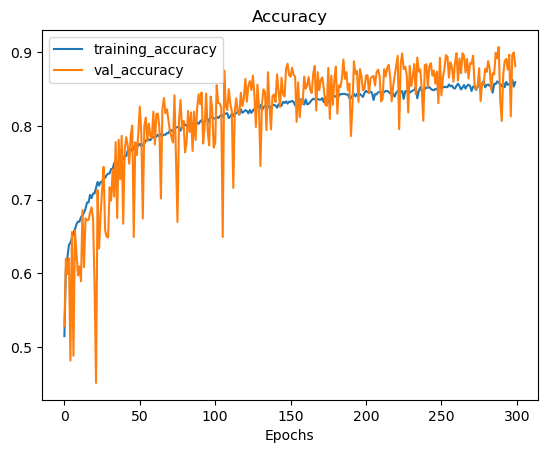

In [12]:
plot_loss_curves(cnn_model.history)

In [13]:
# Define Paths
dataset_dir = "test_dataset"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

Class: Mild Dementia, Files Found: 750
Class: Moderate Dementia, Files Found: 73
Class: Non Demented, Files Found: 2250
Class: Very mild Dementia, Files Found: 2059


In [30]:
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)  # Read the image from the path
    image = tf.image.decode_jpeg(image, channels=3)  # Decode the image to RGB
    image = tf.image.resize(image, [128, 128])  # Resize to (128, 128)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

# Load and preprocess a list of images
def load_and_preprocess_images(image_paths):
    # Preprocess all images and store them in a list
    images = [preprocess_image(image_path) for image_path in image_paths]
    
    # Stack the images into a single batch (shape: (batch_size, 128, 128, 3))
    images_batch = tf.stack(images)
    
    return images_batch


test_data = load_and_preprocess_images(image_paths)

# Convert labels to NumPy array
labels = np.array(labels)


161/161 [==============================] - 7s 44ms/step
True Labels: [0 0 0 ... 3 3 3]
Predicted Labels: [0 0 0 ... 3 3 3]
Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       0.90      0.82      0.86       750
 Moderate Dementia       0.00      0.00      0.00        73
      Non Demented       0.90      0.91      0.91      2250
Very mild Dementia       0.85      0.90      0.87      2059

          accuracy                           0.88      5132
         macro avg       0.66      0.66      0.66      5132
      weighted avg       0.87      0.88      0.87      5132



/opt/anaconda3/envs/AAUTIA2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/AAUTIA2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/AAUTIA2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

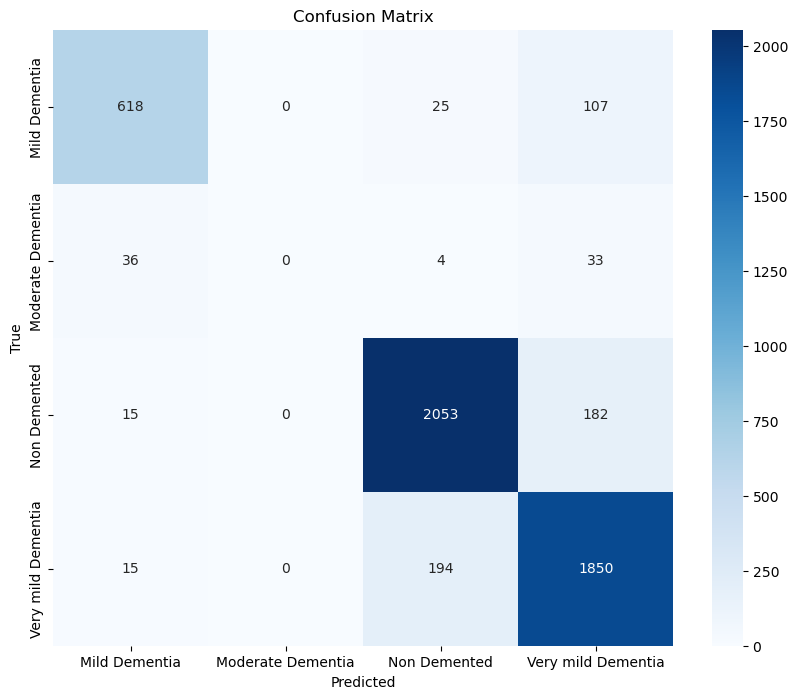

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_true is the actual labels (e.g., integer labels)
y_true = labels  # Actual labels for the test set
predictions = cnn_model.predict(test_data)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

print("True Labels:", y_true)
print("Predicted Labels:", y_pred)

# Classification Report
class_names = classes  # List of class names
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
